In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor


plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

In [12]:
base_df = pd.read_csv('modelling_base_data.csv')

In [13]:
base_df.head()

,Unnamed: 0,pickup_hour,cnt,zip_code,description,is_weekend,weekday,hour,weeknum,month,day
0,0,2015-01-01 00:00:00,835,25,15,0,3,0,1,1,1
1,1,2015-01-01 00:00:00,37,253,15,0,3,0,1,1,1
2,2,2015-01-01 00:00:00,1367,16,15,0,3,0,1,1,1
3,3,2015-01-01 00:00:00,3,290,15,0,3,0,1,1,1
4,4,2015-01-01 00:00:00,54,67,15,0,3,0,1,1,1


In [14]:
base_df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [4]:
# def split_train_and_test(df, date):
#     """
#     Split to train and test data based on given date
#     """
#     train_df = df[df['pickup_hour'] < date]
#     test_df = df[df['pickup_hour'] >= date]
#     return train_df, test_df

In [58]:
### 2015 data as train set
target_col = 'cnt'
feature_cols = ['zip_code', 'description', 'is_weekend', 'weekday', 'hour', 'day']

X_train = base_df[feature_cols]
y_train = base_df[target_col]


In [59]:
def evaluation(model, y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([model, mae, mse], index=['model', 'mae', 'mse'], columns=['score']).T
    return score

In [101]:
### Test data with 2016

test_df_2016 = pd.read_csv('nyc-taxi-weather-combined-2016.csv')
test_df_2016


,pickup_hour,city,cnt,zip_code,description,is_weekend,date,weekday,hour,weeknum
0,2016-01-01 00:00:00,New York city,9.0,11370.0,broken clouds,0,2016-01-01,4,0,53
1,2016-01-01 00:00:00,New York city,11.0,10154.0,broken clouds,0,2016-01-01,4,0,53
2,2016-01-01 00:00:00,New York city,85.0,11106.0,broken clouds,0,2016-01-01,4,0,53
3,2016-01-01 00:00:00,New York city,9.0,10468.0,broken clouds,0,2016-01-01,4,0,53
4,2016-01-01 00:00:00,New York city,9.0,10455.0,broken clouds,0,2016-01-01,4,0,53
...,...,...,...,...,...,...,...,...,...,...
517477,2016-06-30 23:00:00,New York city,2.0,11374.0,scattered clouds,0,2016-06-30,3,23,26
517478,2016-06-30 23:00:00,New York city,29.0,10031.0,scattered clouds,0,2016-06-30,3,23,26
517479,2016-06-30 23:00:00,New York city,6.0,11225.0,scattered clouds,0,2016-06-30,3,23,26
517480,2016-06-30 23:00:00,New York city,52.0,10282.0,scattered clouds,0,2016-06-30,3,23,26


In [102]:
test_df_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517482 entries, 0 to 517481
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   pickup_hour  517482 non-null  object 
 1   city         517482 non-null  object 
 2   cnt          517482 non-null  float64
 3   zip_code     517482 non-null  float64
 4   description  517482 non-null  object 
 5   is_weekend   517482 non-null  int64  
 6   date         517482 non-null  object 
 7   weekday      517482 non-null  int64  
 8   hour         517482 non-null  int64  
 9   weeknum      517482 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 39.5+ MB


In [103]:
test_df_2016['pickup_hour'] = pd.to_datetime(test_df_2016['pickup_hour'])
test_df_2016['zip_code'] = test_df_2016['zip_code'].astype(object)

In [104]:
test_df_2016['month'] = test_df_2016['pickup_hour'].dt.month
test_df_2016['day'] = test_df_2016['pickup_hour'].dt.day

In [105]:
to_be_labeled_feature_mask = test_df_2016.dtypes==object
categorical_cols = test_df_2016.columns[to_be_labeled_feature_mask].tolist()

In [106]:
to_be_labeled_feature_mask

pickup_hour    False
city            True
cnt            False
zip_code        True
description     True
is_weekend     False
date            True
weekday        False
hour           False
weeknum        False
month          False
day            False
dtype: bool

In [107]:
le = LabelEncoder()
test_df_2016[categorical_cols] = test_df_2016[categorical_cols].apply(lambda col: le.fit_transform(col))

In [108]:
test_df_2016

,pickup_hour,city,cnt,zip_code,description,is_weekend,date,weekday,hour,weeknum,month,day
0,2016-01-01 00:00:00,162,9.0,286,0,0,0,4,0,53,1,1
1,2016-01-01 00:00:00,162,11.0,51,0,0,0,4,0,53,1,1
2,2016-01-01 00:00:00,162,85.0,230,0,0,0,4,0,53,1,1
3,2016-01-01 00:00:00,162,9.0,98,0,0,0,4,0,53,1,1
4,2016-01-01 00:00:00,162,9.0,85,0,0,0,4,0,53,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
517477,2016-06-30 23:00:00,162,2.0,290,14,0,181,3,23,26,6,30
517478,2016-06-30 23:00:00,162,29.0,28,14,0,181,3,23,26,6,30
517479,2016-06-30 23:00:00,162,6.0,255,14,0,181,3,23,26,6,30
517480,2016-06-30 23:00:00,162,52.0,68,14,0,181,3,23,26,6,30


In [109]:
X_test = test_df_2016[feature_cols]
y_test = test_df_2016[target_col]
# X_train = train_df[feature_cols]
# X_test = test_df[feature_cols]
# y_train = train_df[target_col]
# y_test = test_df[target_col]

In [68]:
max_depth=5
learning_rate=0.1
n_estimators=100
n_jobs=-1
num_leaves=31


xgb_reg = XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, n_jobs=n_jobs)
lgm_reg = LGBMRegressor(num_leaves=num_leaves, max_depth=-1, learning_rate=learning_rate, n_estimators=n_estimators)
rf_reg = RandomForestRegressor(n_estimators=n_estimators, n_jobs=n_jobs)

In [69]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [70]:
lgm_reg.fit(X_train, y_train)

LGBMRegressor()

In [71]:
rf_reg.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [110]:
xgb_pred = xgb_reg.predict(X_test)

In [111]:
lgm_pred = lgm_reg.predict(X_test)

In [112]:
rf_pred = rf_reg.predict(X_test)

In [113]:
xgb_eva = evaluation('XGBRegressor', y_test, xgb_pred)
xgb_eva

,model,mae,mse
score,XGBRegressor,44.75,10334


In [114]:
lgm_eva = evaluation('LGBMRegressor', y_test, lgm_pred)
lgm_eva

,model,mae,mse
score,LGBMRegressor,40.3114,9609.95


In [115]:
rf_eva = evaluation('RFR', y_test, rf_pred)
rf_eva

,model,mae,mse
score,RFR,31.9689,7846.18


In [116]:
frames = [xgb_eva, lgm_eva, rf_eva]
evaluation_agg = pd.concat(frames)

<AxesSubplot:title={'center':'Model MSE Comparison'}, xlabel='model'>

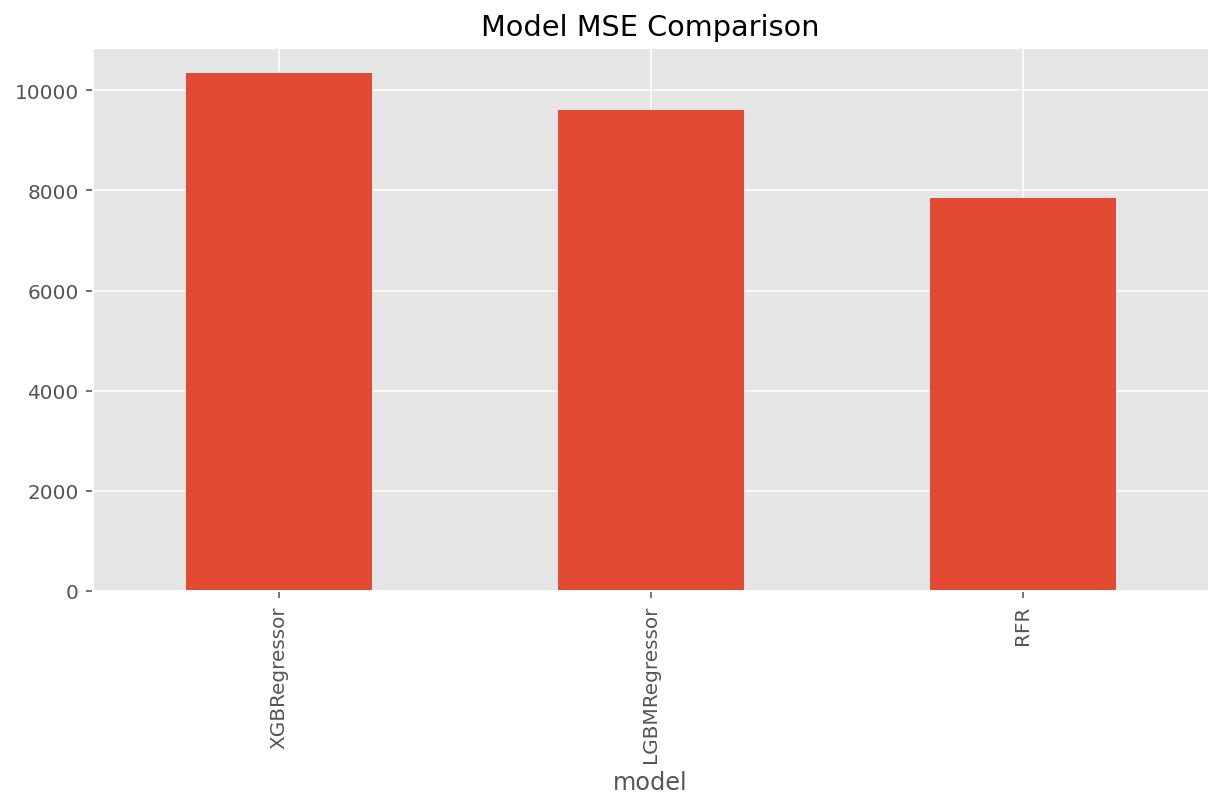

In [117]:
evaluation_agg.set_index('model')['mse'].plot(kind='bar', title='Model MSE Comparison', figsize=(10,5))

<AxesSubplot:title={'center':'XGBR Feature Importance'}>

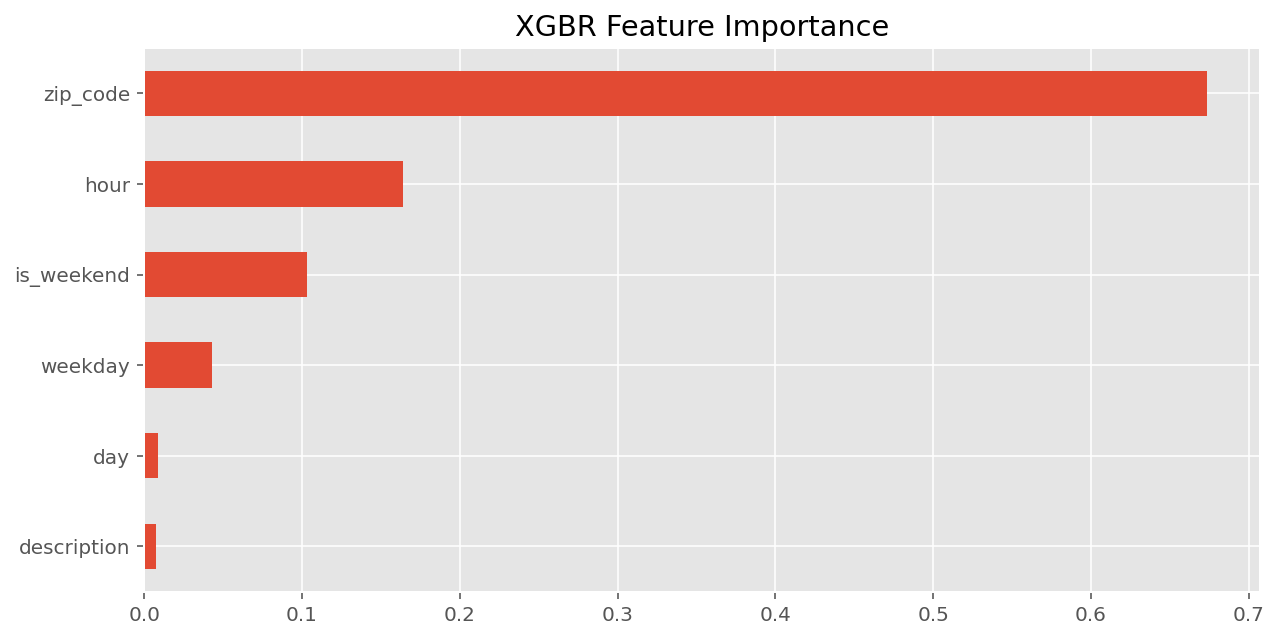

In [118]:
feat_importances = pd.Series(xgb_reg.feature_importances_, index=X_train.columns)
feat_importances.nsmallest(8).plot(kind='barh', title='XGBR Feature Importance', figsize=(10,5))

<AxesSubplot:title={'center':'LGBMR Feature Importance'}>

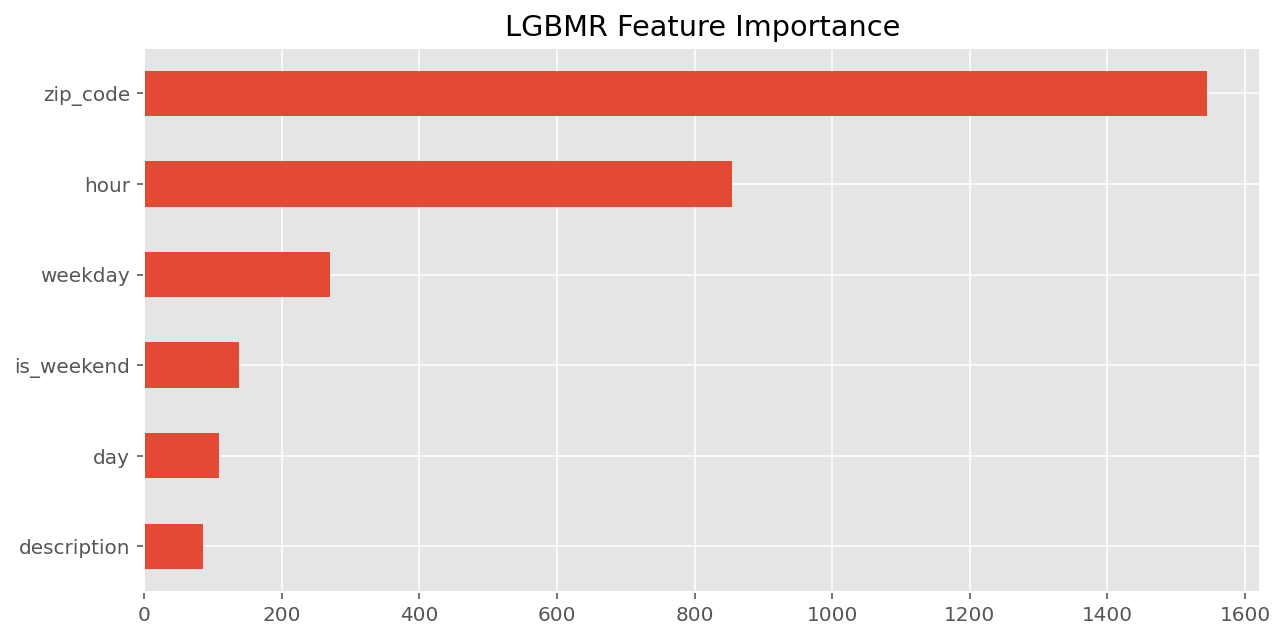

In [119]:
feat_importances_lgbm = pd.Series(lgm_reg.feature_importances_, index=X_train.columns)
feat_importances_lgbm.nsmallest(8).plot(kind='barh', title='LGBMR Feature Importance', figsize=(10,5))

<AxesSubplot:title={'center':'RFR Feature Importance'}>

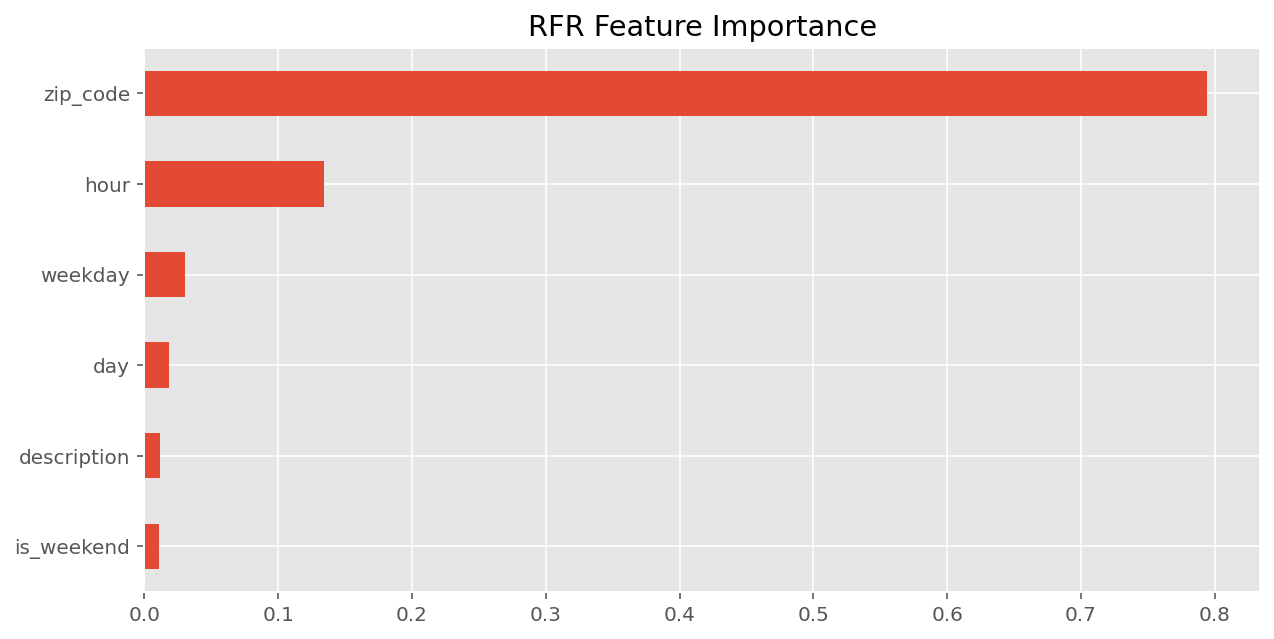

In [120]:
feat_importances_rf = pd.Series(rf_reg.feature_importances_, index=X_train.columns)
feat_importances_rf.nsmallest(8).plot(kind='barh', title='RFR Feature Importance', figsize=(10,5))

In [121]:
test_df_2016['y_true'] = y_test
test_df_2016['y_pred'] = rf_pred
test_df_2016['year'] = 2016
test_df_2016['datetime'] = pd.to_datetime(test_df_2016[['year', 'month', 'day', 'hour']])

In [122]:
test_df_2016.head()

,pickup_hour,city,cnt,zip_code,description,is_weekend,date,weekday,hour,weeknum,month,day,y_true,y_pred,year,datetime
0,2016-01-01,162,9.0,286,0,0,0,4,0,53,1,1,9.0,1.17,2016,2016-01-01
1,2016-01-01,162,11.0,51,0,0,0,4,0,53,1,1,11.0,9.26,2016,2016-01-01
2,2016-01-01,162,85.0,230,0,0,0,4,0,53,1,1,85.0,1.26,2016,2016-01-01
3,2016-01-01,162,9.0,98,0,0,0,4,0,53,1,1,9.0,1.16,2016,2016-01-01
4,2016-01-01,162,9.0,85,0,0,0,4,0,53,1,1,9.0,1.72,2016,2016-01-01


In [124]:
test_df_2016.tail()

,pickup_hour,city,cnt,zip_code,description,is_weekend,date,weekday,hour,weeknum,month,day,y_true,y_pred,year,datetime
517477,2016-06-30 23:00:00,162,2.0,290,14,0,181,3,23,26,6,30,2.0,2.01,2016,2016-06-30 23:00:00
517478,2016-06-30 23:00:00,162,29.0,28,14,0,181,3,23,26,6,30,29.0,26.11,2016,2016-06-30 23:00:00
517479,2016-06-30 23:00:00,162,6.0,255,14,0,181,3,23,26,6,30,6.0,3.41,2016,2016-06-30 23:00:00
517480,2016-06-30 23:00:00,162,52.0,68,14,0,181,3,23,26,6,30,52.0,63.09,2016,2016-06-30 23:00:00
517481,2016-06-30 23:00:00,162,3.0,262,14,0,181,3,23,26,6,30,3.0,7.52,2016,2016-06-30 23:00:00


In [126]:
test_df_2016_jan = test_df_2016[test_df_2016['month'] == 1]
test_df_2016_feb = test_df_2016[test_df_2016['month'] == 2]
test_df_2016_mar = test_df_2016[test_df_2016['month'] == 3]

In [127]:
test_df_2016_jan.groupby('datetime').sum()[['y_true', 'y_pred']]

,y_true,y_pred
datetime,,
2016-01-01 00:00:00,24466.0,16722.663667
2016-01-01 01:00:00,27766.0,11818.883048
2016-01-01 02:00:00,24839.0,6747.015667
2016-01-01 03:00:00,20803.0,4651.556833
2016-01-01 04:00:00,15048.0,4048.782857
...,...,...
2016-01-31 19:00:00,17184.0,17383.232333
2016-01-31 20:00:00,14537.0,15879.580000
2016-01-31 21:00:00,13834.0,14484.911667


<AxesSubplot:title={'center':'NYC Taxi Demand 2016-2 Prediction'}, xlabel='datetime'>

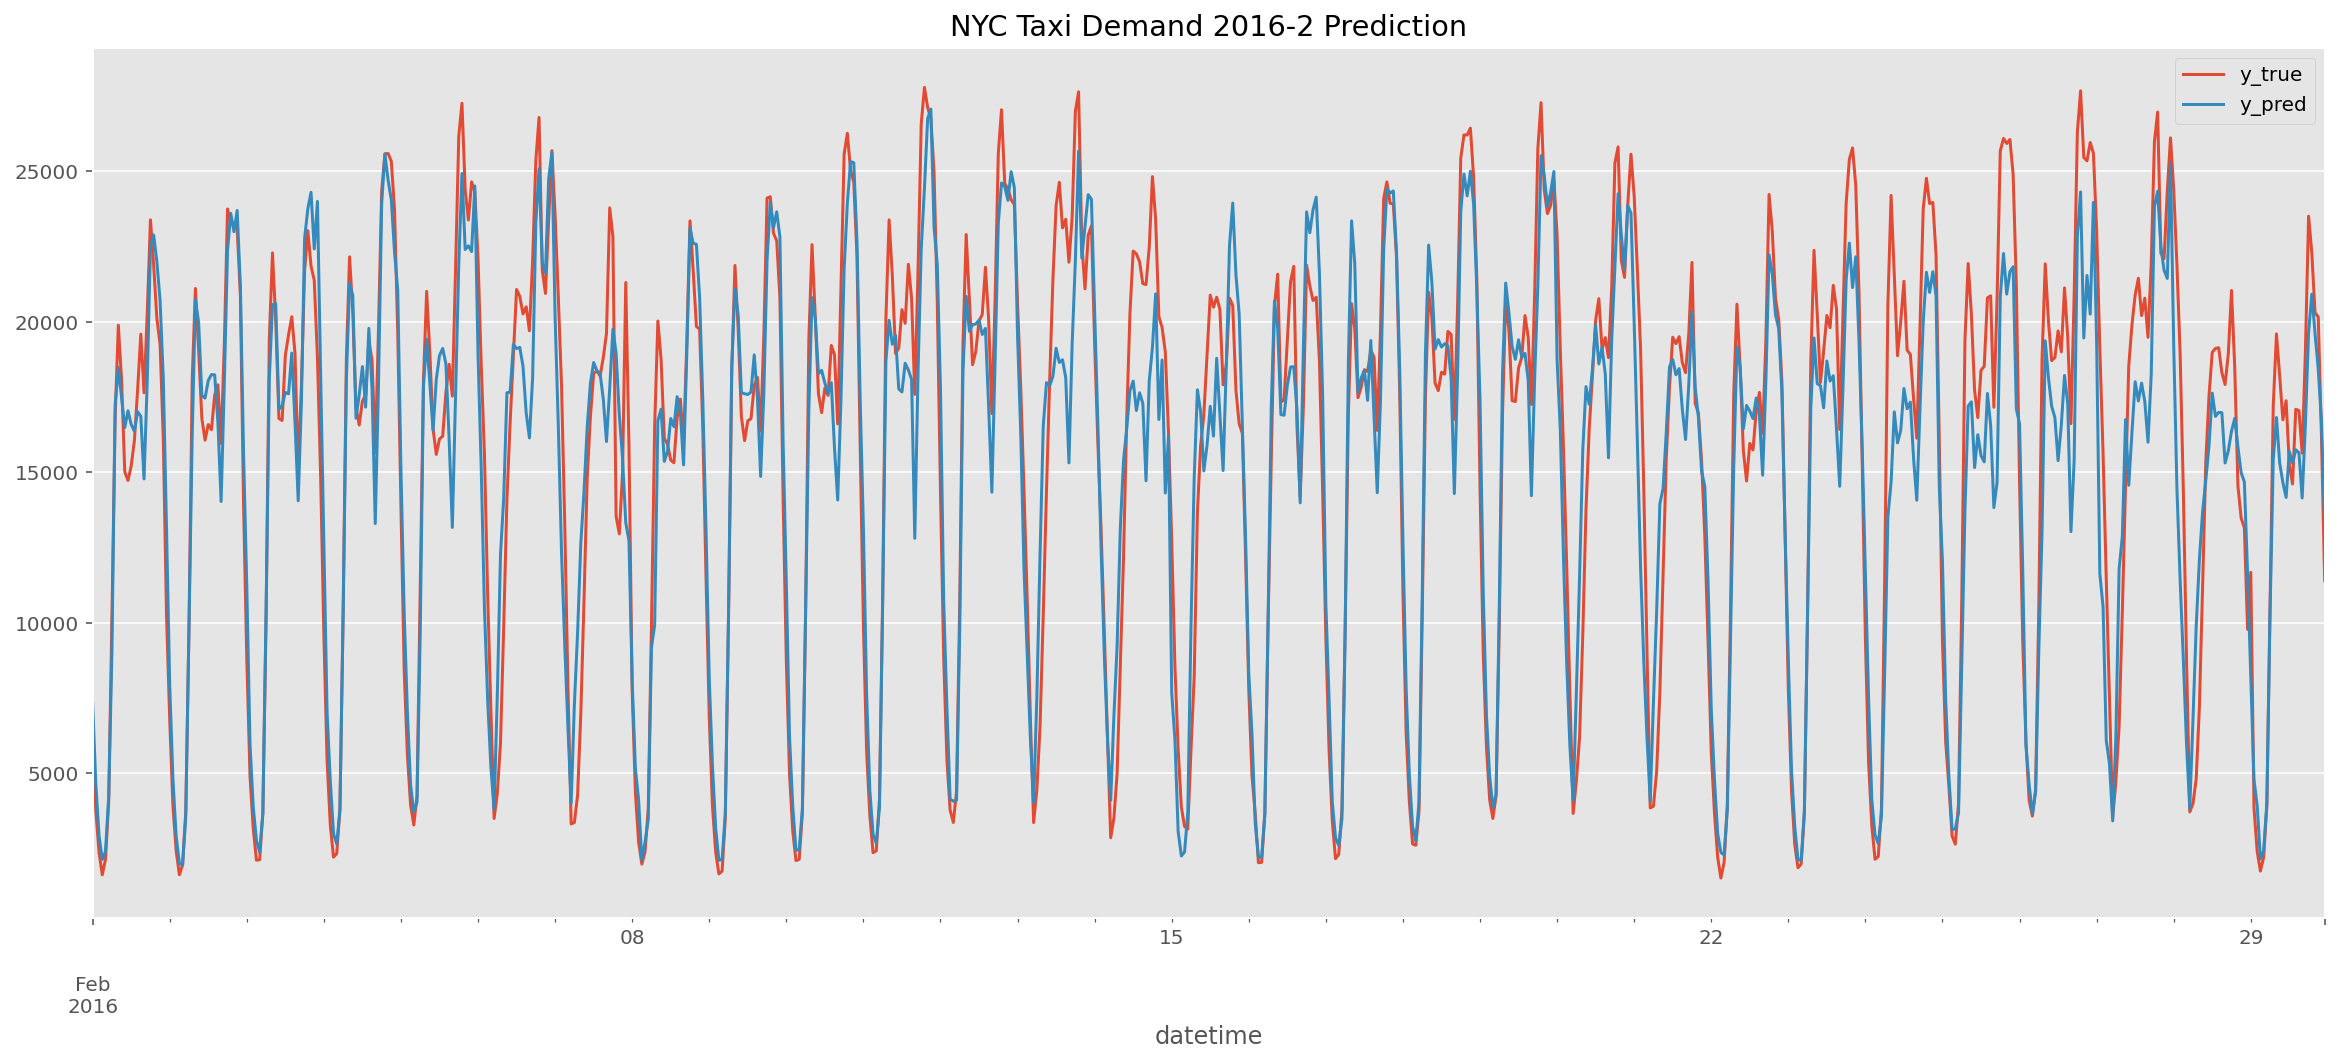

In [134]:

test_df_2016_feb.groupby('datetime').sum()[['y_true', 'y_pred']].plot(figsize=(20,8), title='NYC Taxi Demand 2016-2 Prediction')
#test_df_oct[test_df_oct['datetime'] < '2015-10-04'].groupby('datetime').sum()[['y_true', 'y_pred']].plot(figsize=(20,8), title='NYC Taxi Demand 2015-10 Prediction')

<AxesSubplot:title={'center':'NYC Taxi Demand 2015-10 Prediction'}, xlabel='datetime'>

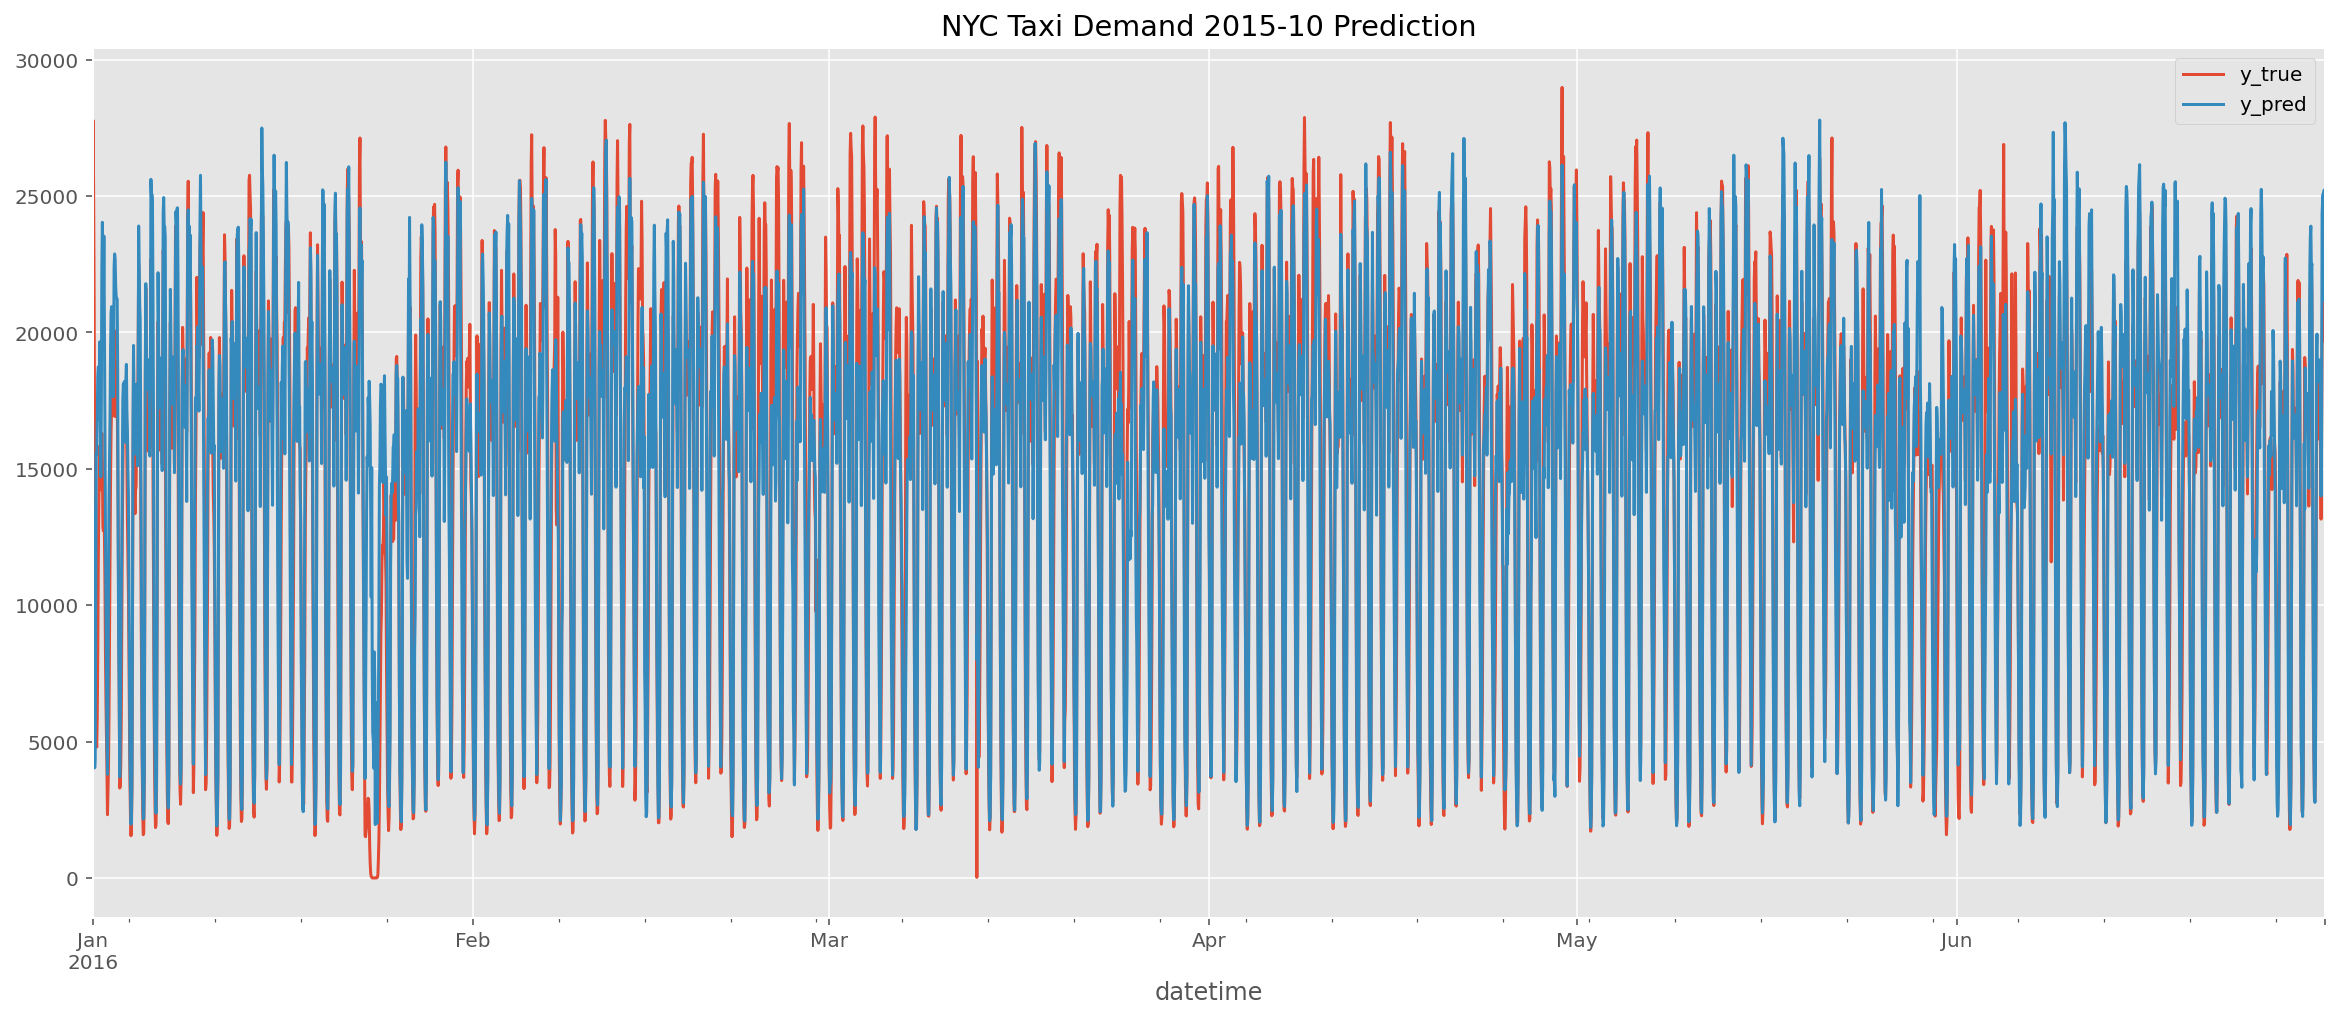

In [140]:
test_df_2016.groupby('datetime').sum()[['y_true', 'y_pred']].plot(figsize=(20,8), title='NYC Taxi Demand 2015-10 Prediction')

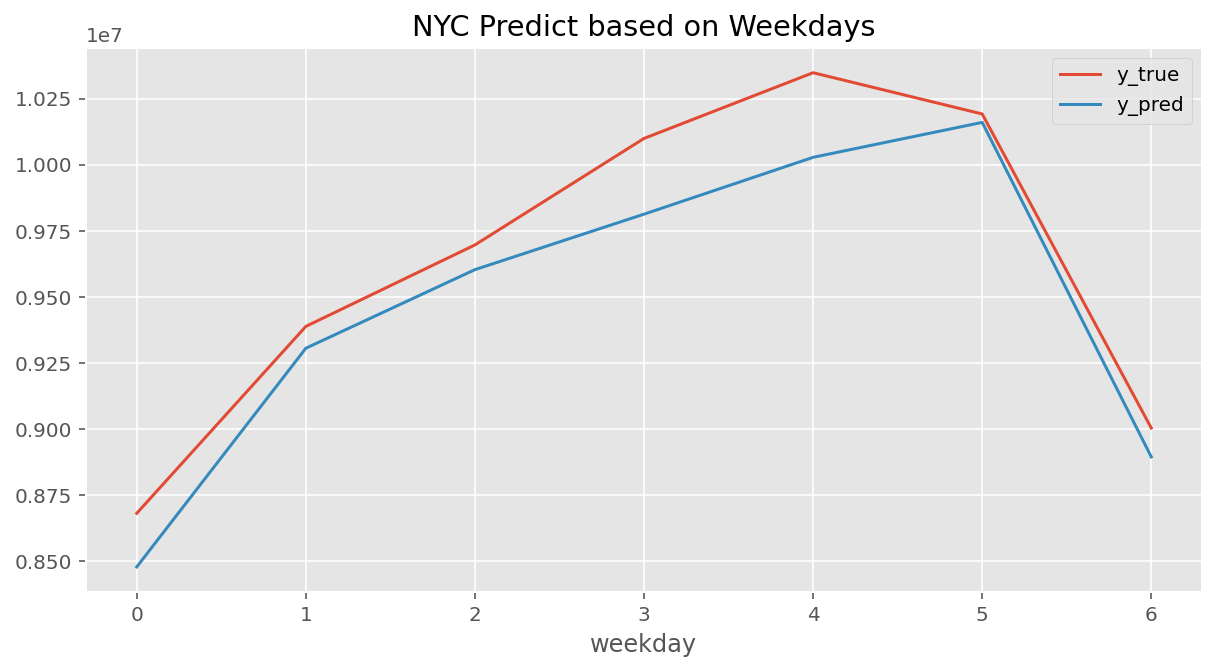

In [138]:
test_df_2016[['weekday','y_true', 'y_pred']].groupby('weekday').sum()[['y_true', 'y_pred']].plot(figsize=(10,5), title='NYC Predict based on Weekdays');

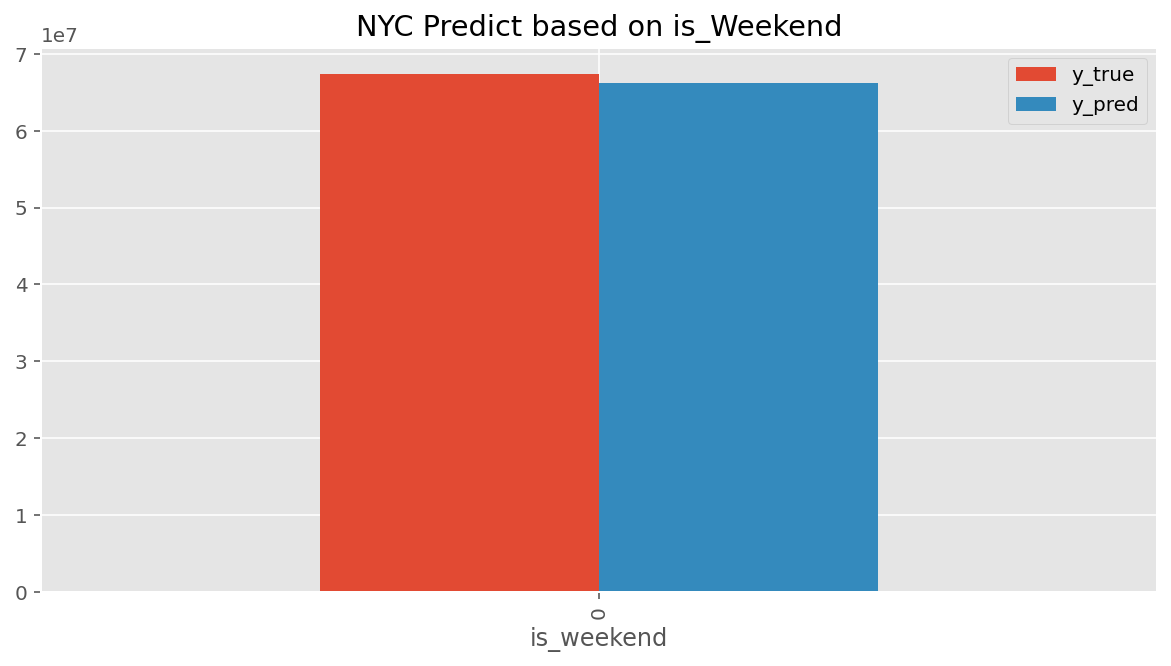

In [139]:
test_df_2016[['is_weekend','y_true', 'y_pred']].groupby('is_weekend').sum()[['y_true', 'y_pred']].plot(kind='bar', figsize=(10,5), title='NYC Predict based on is_Weekend');